In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE = '/content/drive/My Drive/adversarial-attack-filter'
%cd $BASE

/content/drive/My Drive


In [ ]:
from models.architecture import IMDN

import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.transforms as T
import torchvision.models as models

import cv2
from google.colab.patches import cv2_imshow

from torchvision.transforms import functional as func

import numpy as np
import pandas as pd


from PIL import Image

import os

import matplotlib.pyplot as plt

import math
import random


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [ ]:
# tensor 이미지 출력
def print_tensor_image(image) :
  img = image
  if image.dim() == 4 :
    img = img.resize(3, image.shape[2], image.shape[3])
  plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

In [ ]:
# 랜덤하게 img1과 img2의 같은 영역을 crop한 후 그 결과를 반환
def randcrop_two_image(img1, img2) :
  x = random.randint(0, 106)
  y = random.randint(0, 106)
  crop_pos = [x, y, x + 192, y + 192]
  return img1.crop(crop_pos), img2.crop(crop_pos)

In [ ]:
# 두 이미지의 psnr 계산
def caculate_psnr(img1, img2) :
  MSE = torch.mean((img1 - img2)**2)
  return 10*math.log10((255**2) / MSE)

# Load Models

## Original IMDN (X2)

In [ ]:
from collections import OrderedDict
PRETRAINED_IMDN_X2_PATH = 'model_zoo/IMDN/IMDN_x2.pth'

pretrained_weight_x2 = torch.load(PRETRAINED_IMDN_X2_PATH)
pretrained_IMDN_x2 = OrderedDict()

for k, v in pretrained_weight_x2.items() :
  if 'module' in k:
    name = k[7:]
  else :
    name = k
  pretrained_IMDN_x2[name] = v


In [ ]:
imdn_x2 = IMDN(upscale = 2)
imdn_x2.load_state_dict(pretrained_IMDN_x2, strict = True)

<All keys matched successfully>

## Classification models

In [ ]:
cls_model0 = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained = True)
cls_model1 = models.vgg13(pretrained = True)
cls_model2 = models.resnet18(pretrained = True)

cls_model3 = models.efficientnet_b2(pretrained = True)
cls_model4 = models.vgg16(pretrained = True)
cls_model5 = models.squeezenet1_0(pretrained = True)

cls_models = [cls_model0, cls_model1, cls_model2, cls_model3, cls_model4, cls_model5]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


# DataLoader

In [ ]:
df = pd.read_csv('original.csv')

class Dataset(torch.utils.data.Dataset) :
  def __init__(self, offset, len, ds = 2, attack = 'd') :
    self.len = len
    self.offset = offset
    self.ds = ds
    
    self.hr_path = 'datasets/NIPS-DEV/clean/'

    if attack == 'd' :
      self.lr_path = 'datasets/NIPS-DEV/di-2-fgsm/'
    elif attack == 'm' :
      self.lr_path = 'datasets/NIPS-DEV/mdi-2-fgsm/'

    self.ids = df['ImageId']

  def __len__(self) :
    return self.len

  def __getitem__(self, idx) :
    idx = self.offset + idx
    hr, lr =  randcrop_two_image(Image.open(self.hr_path + self.ids[idx] + '.png'), Image.open(self.lr_path + self.ids[idx] + '.png'))
    hr = func.to_tensor(hr)

    lr = lr.resize((int(192/self.ds), int(192/self.ds)), Image.BICUBIC)
    lr = func.to_tensor(lr)
    #lr = self.resize(lr)

    return hr, lr

In [ ]:
batch_size = 16

train_loader = DataLoader(Dataset(0, 800), batch_size = batch_size, shuffle = True)
val_loader = DataLoader(Dataset(800, 100), batch_size = batch_size, shuffle = True)
test_loader = DataLoader(Dataset(900, 100), batch_size = batch_size, shuffle = True)

# Fine-tuning 이전 성능 확인

## 필터 성능

In [ ]:
preprocess = T.Compose([
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def check_validation_accuracy(sr_model, cls_model, downsample = 1, attack = None) :
  if sr_model != None :
    sr_model.to(device)
    sr_model.eval()
  idx = 800
  ids = df.iloc[800:900]['ImageId']

  sum = 0

  cls_model.to(device)
  cls_model.eval()

  with torch.no_grad() :
    for id in ids :
      if attack == None :
        img = Image.open('datasets/NIPS-DEV/clean/' + id + '.png')
      elif attack == 'd' :
        img = Image.open('datasets/NIPS-DEV/di-2-fgsm/' + id + '.png')
      elif attack == 'm' :
        img = Image.open('datasets/NIPS-DEV/mdi-2-fgsm/' + id + '.png')
      
      img = img.resize((math.ceil(299/downsample), math.ceil(299/downsample)), Image.BICUBIC)

      img = func.to_tensor(img).unsqueeze(0).to(device)
      if sr_model != None :
        img = sr_model(img)

      img = preprocess(img)
      pred = cls_model(img)
      pred = torch.argmax(pred) + 1
      
      if df.loc[idx]['TrueLabel'] == pred :
        sum = sum + 1
      idx = idx + 1

  return (sum / 100.)*100

In [ ]:
def check_validation_accuracy_all_type(sr_model, cls_model, downsample ) :
  no = check_validation_accuracy(sr_model = sr_model, cls_model = cls_model, downsample = downsample, attack = None)
  di = check_validation_accuracy(sr_model = sr_model, cls_model = cls_model, downsample = downsample, attack = 'd')
  mdi = check_validation_accuracy(sr_model = sr_model, cls_model = cls_model, downsample = downsample, attack = 'm')
  
  print('Clean : ', no)
  print('Di2 : ', di)
  print('Mdi2 : ', mdi)

No defense

In [ ]:
check_validation_accuracy_all_type(sr_model = None, cls_model = cls_model1, downsample = 1)

IMDN_x2 : <br>
Clean : 90<br>
Di2 : 40<br>
Mdi2 : 22<br>

IMDNX_x2 DS : 2, US 2 <br>
Clean : 95<br>
Di2 : 3<br>
Mdi2 : 4<br>

# Adversarial training

## Training - classification model ensemble mse

In [ ]:
def classification(cls_model, x) :
  preds = cls_model(x)
  
  return preds

In [ ]:
def train_by_cls_model(model, cls_models, optimizer, data_loader, val_loader, epochs = 1, verb = False, log = None) :
  model = model.to(device)
  model.train()

  best_model = IMDN(upscale = 2)
  best_model.to(device)

  cls_models[0].to(device)
  cls_models[0].eval()
  
  cls_models[1].to(device)
  cls_models[1].eval()

  cls_models[2].to(device)
  cls_models[2].eval()
  
  if log == None : 
    log = {'Val acc0' : [], 'Val acc1' : [], 'Val acc2' : [], 'Mean loss' : [],
           'Val acc3' : [], 'Val acc4' : [], 'Val acc5' : [], 'Val Acc Gain' : []}

  loss_func = nn.MSELoss()

  val_acc0 = check_validation_accuracy(model, cls_models[0], downsample = 2, attack = 'd')
  val_acc1 = check_validation_accuracy(model, cls_models[1], downsample = 2, attack = 'd')
  val_acc2 = check_validation_accuracy(model, cls_models[2], downsample = 2, attack = 'd')
  
  val_acc3 = check_validation_accuracy(model, cls_models[3], downsample = 2, attack = 'd')
  val_acc4 = check_validation_accuracy(model, cls_models[4], downsample = 2, attack = 'd')
  val_acc5 = check_validation_accuracy(model, cls_models[5], downsample = 2, attack = 'd')
  
  
  print('Val acc 0:', val_acc0)
  log['Val acc0'].append(val_acc0)
  print('Val acc 1:', val_acc1)
  log['Val acc1'].append(val_acc1)  
  print('Val acc 2:', val_acc2)
  log['Val acc2'].append(val_acc2)

  print('Val acc 3:', val_acc3)
  log['Val acc3'].append(val_acc3)
  print('Val acc 4:', val_acc4)
  log['Val acc4'].append(val_acc4)  
  print('Val acc 5:', val_acc5)
  log['Val acc5'].append(val_acc5)

  first_acc3 = val_acc3
  first_acc4 = val_acc4
  first_acc5 = val_acc5

  max = 0

  for e in range(epochs) :
    model.train()
    print(f'{e + 1} / {epochs}')
    sum = 0.
    for t, (hr, lr) in enumerate(data_loader) : 
      hr = hr.to(device)
      lr = lr.to(device)

      preds = model(lr)

      hr = preprocess(hr)
      preds = preprocess(preds)

      cls1_hr = classification(cls_models[0], hr)
      cls1_preds = classification(cls_models[0], preds)
      loss1 = loss_func(cls1_preds, cls1_hr)

      cls2_hr = classification(cls_model2, hr)
      cls2_preds = classification(cls_model2, preds)
      loss2 = loss_func(cls2_preds, cls2_hr)

      cls3_hr = classification(cls_model3, hr)
      cls3_preds = classification(cls_model3, preds)
      loss3 = loss_func(cls3_preds, cls3_hr)

      # ensemble
      loss = loss1 + loss2 + loss3

      sum = sum + loss.item()

      if verb :
        print(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    val_acc0 = check_validation_accuracy(model, cls_models[0], downsample = 2, attack = 'd')
    val_acc1 = check_validation_accuracy(model, cls_models[1], downsample = 2, attack = 'd')
    val_acc2 = check_validation_accuracy(model, cls_models[2], downsample = 2, attack = 'd')

    val_acc3 = check_validation_accuracy(model, cls_models[3], downsample = 2, attack = 'd')
    val_acc4 = check_validation_accuracy(model, cls_models[4], downsample = 2, attack = 'd')
    val_acc5 = check_validation_accuracy(model, cls_models[5], downsample = 2, attack = 'd')

    print('Val acc 0:', val_acc0)
    log['Val acc0'].append(val_acc0)
    print('Val acc 1:', val_acc1)
    log['Val acc1'].append(val_acc1)
    print('Val acc 2:', val_acc2)
    log['Val acc2'].append(val_acc2)

    print('Val acc 3:', val_acc3)
    log['Val acc3'].append(val_acc3)
    print('Val acc 4:', val_acc4)
    log['Val acc4'].append(val_acc4)  
    print('Val acc 5:', val_acc5)
    log['Val acc5'].append(val_acc5)

    
    gain = (val_acc3 - first_acc3) + (val_acc4 - first_acc4) + (val_acc5 - first_acc5)
    log['Val Acc Gain'].append(gain)

    if gain > max :
      max = gain
      print('Max gain record : ', max)
      best_model.load_state_dict(model.state_dict())

    mean_loss = sum / 50.
    print('Mean loss : ', mean_loss)
    log['Mean loss'].append(mean_loss)
    
  return best_model, log

In [ ]:
model = IMDN(upscale = 2)
model.load_state_dict(pretrained_IMDN_x2, strict = True)

<All keys matched successfully>

In [ ]:
lr = 2e-4

optimizer = optim.Adam(params = model.parameters(), lr = lr)

In [ ]:
best_model, log = train_by_cls_model(model, cls_models, optimizer, train_loader, val_loader, epochs = 100, verb = True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
2.792073965072632
2.3771815299987793
Val acc 0: 53.0
Val acc 1: 66.0
Val acc 2: 77.0
Val acc 3: 89.0
Val acc 4: 70.0
Val acc 5: 62.0
Mean loss :  2.4173151636123658
15 / 100
2.4722981452941895
2.452247142791748
2.084517240524292
2.407585859298706
2.0983266830444336
2.604036331176758
3.219203472137451
2.391627073287964
2.177617073059082
1.9498413801193237
2.3960726261138916
3.261510133743286
1.8471765518188477
2.6459970474243164
2.671325206756592
2.731637477874756
2.48970890045166
2.5270466804504395
2.064588785171509
2.1132266521453857
2.2630510330200195
2.7481143474578857
2.526277542114258
1.8470921516418457
2.413454294204712
2.2688825130462646
2.352336883544922
2.262028217315674
2.1553962230682373
2.721050262451172
2.308387279510498
2.274461269378662
2.6985344886779785
2.581967353820801
2.3727872371673584
1.8846142292022705
2.7949256896972656
2.8434460163116455
2.1817145347595215
2.072694778442383
2.1875925064086914
2.173884153366089
2.2537500858306

In [ ]:
val_acc3 = check_validation_accuracy(best_model, cls_models[3], downsample = 2, attack = 'd')
val_acc4 = check_validation_accuracy(best_model, cls_models[4], downsample = 2, attack = 'd')
val_acc5 = check_validation_accuracy(best_model, cls_models[5], downsample = 2, attack = 'd')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [ ]:
torch.save(model.state_dict(), 'model_zoo/ours/adv_ens_imdn_best.pt') # save best model

In [ ]:
pd.DataFrame({'Val acc0' : log['Val acc0'], 'Val acc1' : log['Val acc1'], 'Val acc2' : log['Val acc2'], 'Val_acc3' : log['Val acc3'],
              'Val acc4' : log['Val acc4'],'Val acc5' : log['Val acc5']}).to_csv('adv_ens_imdn_v1_best_acc.csv')

In [ ]:
pd.DataFrame({'Mean loss' : log['Mean loss'], 'Gain' : log['Val Acc Gain']}).to_csv('adv_ens_imdn_v1_best_loss.csv')

In [ ]:
pd.DataFrame({'Val acc0' : log['Val acc0'], 'Val acc1' : log['Val acc1'], 'Val acc2' : log['Val acc2']}).to_csv('Adv_ens_imdn_v1-Acc.csv')
pd.DataFrame({'Mean loss' : log['Mean loss']}).to_csv('Adv_ens_imdn_v1-loss.csv')

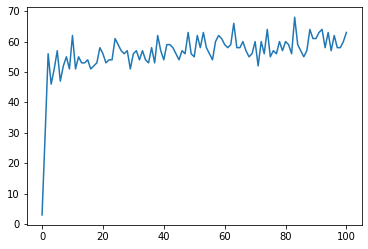

In [ ]:
plt.plot(log['Val acc0'])

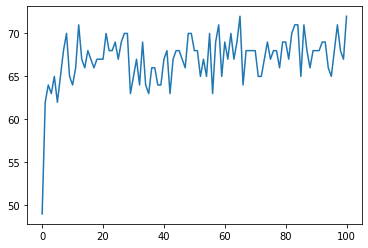

In [ ]:
plt.plot(log['Val acc1'])

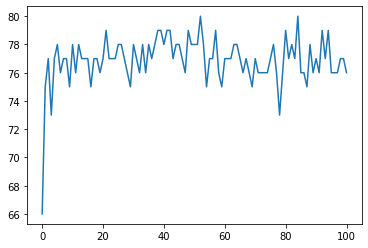

In [ ]:
plt.plot(log['Val acc2'])

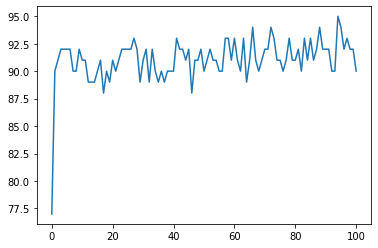

In [ ]:
plt.plot(log['Val acc3'])

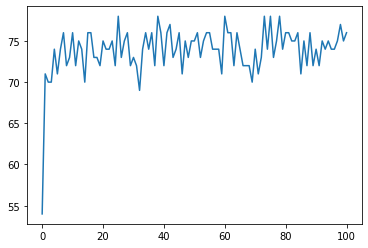

In [ ]:
plt.plot(log['Val acc4'])

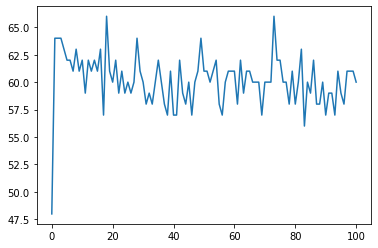

In [ ]:
plt.plot(log['Val acc5'])

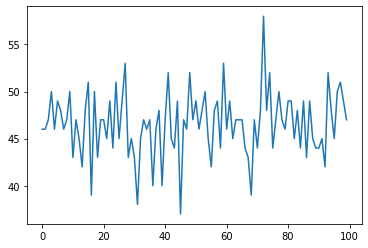

In [ ]:
plt.plot(log['Val Acc Gain'])

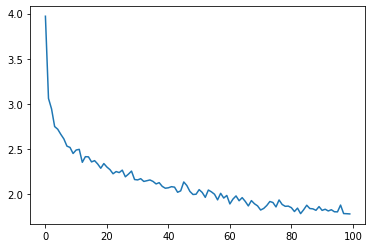

In [ ]:
plt.plot(log['Mean loss'])

# Check Visual Results



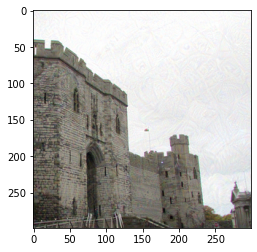

In [ ]:
temp = Image.open('datasets/NIPS-DEV/di-2-fgsm/0ceee9a38409e30c.png')
temp = func.to_tensor(temp)
print_tensor_image(temp)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


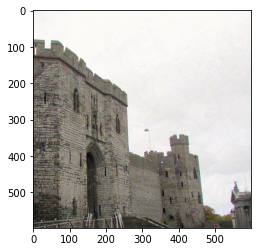

In [ ]:
print_tensor_image(model(temp.unsqueeze(0).to(device)).to('cpu').detach())